**Aluno**: Álysson de Sá Soares

**E-mail**: ass5@cesar.school

**Dataset**: [Date Fruit Datasets](https://www.kaggle.com/datasets/muratkokludataset/date-fruit-datasets/data)

> Obs.: Os dados também estão disponíveis no [github](https://github.com/alyssondss42/RNA-DL-CESAR-School/raw/refs/heads/master/Trabalho%20Final/data).



# Preparação do ambiente

In [163]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import torch

# Carregamento dos dados

In [223]:
# download dataset
url = "https://github.com/alyssondss42/RNA-DL-CESAR-School/raw/refs/heads/master/Trabalho%20Final/data/Date_Fruit_Datasets.xlsx"
response = requests.get(url)

dest = 'Date_Fruit_Datasets.xlsx'

with open(dest, 'wb') as file:
  file.write(response.content)

In [224]:
df = pd.read_excel(dest)
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           898 non-null    int64  
 1   PERIMETER      898 non-null    float64
 2   MAJOR_AXIS     898 non-null    float64
 3   MINOR_AXIS     898 non-null    float64
 4   ECCENTRICITY   898 non-null    float64
 5   EQDIASQ        898 non-null    float64
 6   SOLIDITY       898 non-null    float64
 7   CONVEX_AREA    898 non-null    int64  
 8   EXTENT         898 non-null    float64
 9   ASPECT_RATIO   898 non-null    float64
 10  ROUNDNESS      898 non-null    float64
 11  COMPACTNESS    898 non-null    float64
 12  SHAPEFACTOR_1  898 non-null    float64
 13  SHAPEFACTOR_2  898 non-null    float64
 14  SHAPEFACTOR_3  898 non-null    float64
 15  SHAPEFACTOR_4  898 non-null    float64
 16  MeanRR         898 non-null    float64
 17  MeanRG         898 non-null    float64
 18  MeanRB    

Pelo .info() é possível notar que não existem dados nulos na base.

In [11]:
df.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,...,898.000000,898.000000,898.000000,898.000000,8.980000e+02,8.980000e+02,8.980000e+02,898.000000,898.000000,898.000000
mean,298295.207127,2057.660953,750.811994,495.872785,0.737468,604.577938,0.981840,303845.592428,0.736267,2.131102,...,0.250518,4.247845,5.110894,3.780928,-3.185021e+10,-2.901860e+10,-2.771876e+10,50.082888,48.805681,48.098393
std,107245.205337,410.012459,144.059326,114.268917,0.088727,119.593888,0.018157,108815.656947,0.053745,17.820778,...,0.632918,2.892357,3.745463,2.049831,2.037241e+10,1.712952e+10,1.484137e+10,16.063125,14.125911,10.813862
min,1987.000000,911.828000,336.722700,2.283200,0.344800,50.298400,0.836600,2257.000000,0.512300,1.065300,...,-1.029100,1.708200,1.607600,1.767200,-1.091224e+11,-9.261697e+10,-8.747177e+10,15.191100,20.524700,22.130000
25%,206948.000000,1726.091500,641.068650,404.684375,0.685625,513.317075,0.978825,210022.750000,0.705875,1.373725,...,-0.196950,2.536625,2.508850,2.577275,-4.429444e+10,-3.894638e+10,-3.564534e+10,38.224425,38.654525,39.250725
50%,319833.000000,2196.345450,791.363400,495.054850,0.754700,638.140950,0.987300,327207.000000,0.746950,1.524150,...,0.135550,3.069800,3.127800,3.080700,-2.826156e+10,-2.620990e+10,-2.392928e+10,53.841300,50.337800,49.614100
75%,382573.000000,2389.716575,858.633750,589.031700,0.802150,697.930525,0.991800,388804.000000,0.775850,1.674750,...,0.593950,4.449850,7.320400,4.283125,-1.460482e+10,-1.433105e+10,-1.660367e+10,63.063350,59.573600,56.666675
max,546063.000000,2811.997100,1222.723000,766.453600,1.000000,833.827900,0.997400,552598.000000,0.856200,535.525700,...,3.092300,26.171100,26.736700,32.249500,-1.627316e+08,-5.627727e+08,-4.370435e+08,79.828900,83.064900,74.104600


Com a visualização do describe, é possível notar as diferentes escalas entre as features dos dataset. Deste modo, uma normalização dos dados seria importante para o modelo.

In [12]:
df['Class'].value_counts()

,count
Class,
DOKOL,204
SAFAVI,199
ROTANA,166
DEGLET,98
SOGAY,94
IRAQI,72
BERHI,65


Analisando a distribuição das classes dos dados, nota-se que não há um balanceamento na distribuição, tendo a classe maioritária 204 exemplos e a minoritária 65.

Essa informação deve ser levada em consideração e analisada ao avaliar o modelo final criado.

Analisando a origem dos dados, existem subdivisões entre os tipos de features das frutas. Sendo elas morfológicas, formato e cor, como se pode ver na tabela abaixo.

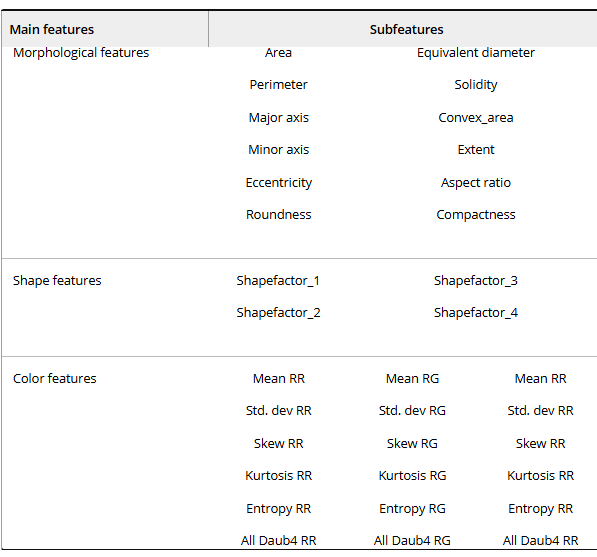

Fonte: [Tabela 1](https://onlinelibrary.wiley.com/doi/10.1155/2021/4793293)

## Pré-processamento

In [164]:
# separacao de features e classes
X_features = df.drop('Class', axis=1)
y_classes = df['Class']

In [165]:
# separacao entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_features, y_classes,
                                                    test_size=0.2,
                                                    random_state=42)

In [166]:
# normalizar os dados com Std scaler
scaler = StandardScaler()

In [167]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns)

In [168]:
X_train_scaled.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
count,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,...,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02,7.180000e+02
mean,-1.335979e-16,-1.335979e-16,3.612091e-16,4.304820e-16,-1.088575e-15,-4.700666e-17,-1.657603e-15,7.916911e-17,-1.819652e-15,2.474035e-17,...,4.082157e-17,-7.916911e-17,1.088575e-16,2.616292e-16,2.474035e-17,-1.187537e-16,2.474035e-17,-5.838722e-16,2.968842e-17,4.403782e-16
std,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,...,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00,1.000697e+00
min,-2.791917e+00,-2.832835e+00,-2.904738e+00,-4.324221e+00,-4.400983e+00,-4.653217e+00,-7.950677e+00,-2.803273e+00,-4.179471e+00,-6.105082e-02,...,-2.035885e+00,-8.833019e-01,-9.648248e-01,-9.735295e-01,-3.736498e+00,-3.652083e+00,-3.974777e+00,-2.140563e+00,-1.970059e+00,-2.370747e+00
25%,-8.574512e-01,-8.023964e-01,-7.633316e-01,-7.302662e-01,-6.039111e-01,-7.627296e-01,-1.800859e-01,-8.496082e-01,-5.903443e-01,-4.575127e-02,...,-6.967419e-01,-5.930003e-01,-7.150458e-01,-5.798525e-01,-6.321897e-01,-5.899061e-01,-5.481560e-01,-7.975100e-01,-7.576282e-01,-8.422198e-01
50%,2.241439e-01,3.497719e-01,2.957100e-01,-1.212337e-02,1.930536e-01,2.998565e-01,2.952173e-01,2.538178e-01,2.037021e-01,-3.801864e-02,...,-1.701276e-01,-4.062405e-01,-5.184846e-01,-3.202295e-01,1.928645e-01,1.895858e-01,2.960457e-01,2.274617e-01,1.048878e-01,8.404378e-02
75%,7.706901e-01,7.994969e-01,7.374867e-01,7.973226e-01,7.294074e-01,7.636805e-01,5.527303e-01,7.703832e-01,7.416497e-01,-3.038769e-02,...,5.497579e-01,7.907620e-02,6.224534e-01,2.446585e-01,8.458733e-01,8.579196e-01,7.451386e-01,8.235572e-01,7.676003e-01,7.966848e-01
max,2.281406e+00,1.816712e+00,3.244301e+00,2.335573e+00,2.943198e+00,1.886756e+00,8.595543e-01,2.259384e+00,2.260919e+00,2.677521e+01,...,4.479841e+00,7.444599e+00,5.832211e+00,1.349629e+01,1.525425e+00,1.630579e+00,1.815923e+00,1.869825e+00,2.438780e+00,2.422703e+00


In [169]:
# converter a classe y com encoder
encoder = LabelEncoder()

y_train = pd.DataFrame(encoder.fit_transform(y_train), columns=['Class'])
y_test = pd.DataFrame(encoder.transform(y_test), columns=['Class'])

In [170]:
# Mapeamento das classes feito pelo encoder
dict_map = {}
for k, v in enumerate(encoder.classes_):
    dict_map[k] = v

In [171]:
dict_map

{0: 'BERHI',
 1: 'DEGLET',
 2: 'DOKOL',
 3: 'IRAQI',
 4: 'ROTANA',
 5: 'SAFAVI',
 6: 'SOGAY'}

Esse é o dicionário das conversões feitas pelo encoder, desta forma será possível avaliar com as classes reais ao final do processo.

## Conversão para formato pytorch

In [172]:
# conversao para tensores
X_train_tensor = torch.FloatTensor(X_train_scaled.values)
X_test_tensor = torch.FloatTensor(X_test_scaled.values)

y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

In [173]:
# criacao dos datasets de treino e teste
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)

In [174]:
# criacao do dataloader com batch = 8
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True)

# Definição da rede

In [203]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense = nn.Sequential(
            # 34 features de entrada
            nn.Linear(in_features=34, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=7)
            # 7 classes de frutas
        )
    def forward(self, x):
      x = self.dense(x)
      output = F.log_softmax(x, dim=1)
      return output

In [176]:
# metodo para predicao de classe
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

In [187]:
model = Net()

In [178]:
# sample para verificacao da rede
x_sample = X_train_tensor[:1]
x_sample

tensor([[ 0.5869,  0.7731,  0.6549,  0.4356,  0.2956,  0.6119,  0.3117,  0.5702,
          0.4518, -0.0368, -0.7216, -0.0820, -0.0562, -0.6589, -0.1306,  0.3353,
          0.3006, -0.1623, -0.0249,  0.7258,  0.1371, -1.2460,  0.0660, -0.2532,
          0.1974, -0.5997, -0.6691,  0.4640, -0.6738, -0.1339, -0.2702,  0.3009,
         -0.1621, -0.0246]])

In [179]:
# testando inicializacao da rede
predict(model, x_sample)

array([1])

In [180]:
# verificando o dataloader
for batch in dataloader_train:
  print(batch[0].shape)
  print(batch[1].shape)
  break

torch.Size([8, 34])
torch.Size([8, 1])


In [188]:
# arquitetura do modelo
model

Net(
  (dense): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
)

# Treinamento do modelo

In [200]:
# metodo de treino
def train(model, train_loader, optimizer, epoch, log_interval=10):
  total_loss = 0
  model.train()
  for batch_idx, (data_features, data_class) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data_features)
    loss = F.nll_loss(output, data_class.squeeze(1))
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data_features), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  return total_loss / len(train_loader)

In [198]:
# metodo para teste/validacao
def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  # no_grad para nao realizar o calculo do gradiente
  with torch.no_grad():
    for data_features, data_class in test_loader:
      output = model(data_features)
      test_loss += F.nll_loss(output, data_class.squeeze(1),
                              reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(data_class.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  acc = 100. * correct / len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), acc))

  return acc, test_loss

In [213]:
# treino do modelo
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.1, weight_decay=1e-4)

epochs = 100
patience = 5
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# melhor acc iniciando em -1
best_acc = -1

# params para realizar early stopping
counter_ptc = 0
best_loss = float('inf')

# lista de loss
loss_list_train = []
loss_list_test = []

# loop de treino e teste
for epoch in range(1, epochs + 1):
  loss_train = train(model, dataloader_train, optimizer, epoch)
  acc_, loss_ = test(model, dataloader_test)
  scheduler.step()

  loss_list_train.append(loss_train)
  loss_list_test.append(loss_)

  if acc_ > best_acc:
    best_acc = acc_
    torch.save(model.state_dict(), 'best_model.pt')

  if loss_ < best_loss:
    best_loss = loss_
    counter_ptc = 0
  else:
    counter_ptc += 1

  if counter_ptc >= patience:
    print("Early stopped")
    break


Train Epoch: 1 [0/718 (0%)]	Loss: 1.922922
Train Epoch: 1 [80/718 (11%)]	Loss: 1.885551
Train Epoch: 1 [160/718 (22%)]	Loss: 1.829821
Train Epoch: 1 [240/718 (33%)]	Loss: 1.974884
Train Epoch: 1 [320/718 (44%)]	Loss: 1.885865
Train Epoch: 1 [400/718 (56%)]	Loss: 1.747627
Train Epoch: 1 [480/718 (67%)]	Loss: 1.328794
Train Epoch: 1 [560/718 (78%)]	Loss: 1.345832
Train Epoch: 1 [640/718 (89%)]	Loss: 1.519758

Test set: Average loss: 0.8676, Accuracy: 121/180 (67%)

Train Epoch: 2 [0/718 (0%)]	Loss: 0.772194
Train Epoch: 2 [80/718 (11%)]	Loss: 1.188010
Train Epoch: 2 [160/718 (22%)]	Loss: 0.851604
Train Epoch: 2 [240/718 (33%)]	Loss: 0.597884
Train Epoch: 2 [320/718 (44%)]	Loss: 0.836207
Train Epoch: 2 [400/718 (56%)]	Loss: 0.628917
Train Epoch: 2 [480/718 (67%)]	Loss: 0.534610
Train Epoch: 2 [560/718 (78%)]	Loss: 0.958823
Train Epoch: 2 [640/718 (89%)]	Loss: 0.895822

Test set: Average loss: 0.5271, Accuracy: 141/180 (78%)

Train Epoch: 3 [0/718 (0%)]	Loss: 0.755729
Train Epoch: 3 [80/71

# Análises de métricas

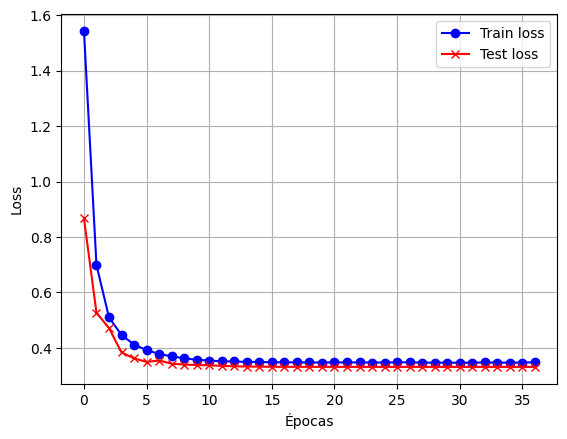

In [214]:
# plot do loss de treino e teste
list_epochs = list(range(0, len(loss_list_train)))
plt.plot(list_epochs, loss_list_train, label='Train loss', color='blue', marker='o')
plt.plot(list_epochs, loss_list_test, label='Test loss', color='red', marker='x')

plt.xlabel('Épocas')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

A curva de loss mostra que o modelo estaria ajustado aos dados. Tendo as suas losses de treino e teste próximas uma da outra.

É possível notar também que após a 5 época o modelo tende a estabilizar, tendo pequenos ganhos de loss até a ativação do early stopping na época 36.

In [215]:
# metodo para gerar as predicoes pelo dataloader
def generate_predictions(model, test_loader):
  model.eval()
  predictions = []

  with torch.no_grad():
      for data_features, _ in test_loader:
          output = model(data_features)
          _, pred = torch.max(output, 1)
          predictions.extend(pred.numpy())

  return predictions

In [216]:
# shufle = False para manter a mesma ordem
loader_predict = DataLoader(dataset_test, batch_size=8, shuffle=False)

In [217]:
# carregando o melhor modelo
best_model = Net()
best_model.load_state_dict(torch.load('best_model.pt'))

# fazendo as predicoes
predictions = generate_predictions(best_model, loader_predict)

<ipython-input-217-b50a1195b819>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pt'))


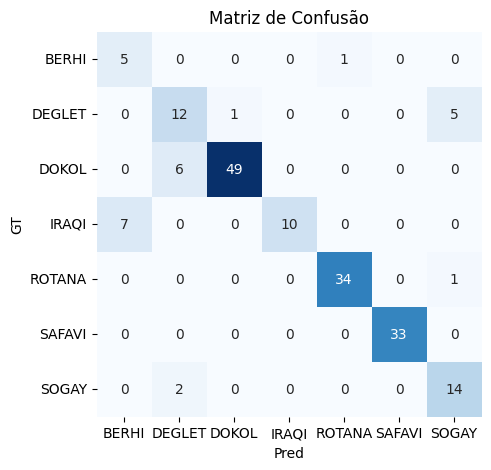

In [222]:
# gerar matriz de confusão
conf_mat = confusion_matrix(predictions, y_test.to_numpy())

# plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=dict_map.values(), yticklabels=dict_map.values())

plt.title('Matriz de Confusão')
plt.xlabel('Pred')
plt.ylabel('GT')

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.show()

In [219]:
# map do label
dict_map

{0: 'BERHI',
 1: 'DEGLET',
 2: 'DOKOL',
 3: 'IRAQI',
 4: 'ROTANA',
 5: 'SAFAVI',
 6: 'SOGAY'}

In [212]:
# análises de taxas de acc, precision, recall e f1
print(classification_report(predictions, y_test.to_numpy()))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.60      0.60      0.60        20
           2       0.96      0.89      0.92        54
           3       1.00      0.67      0.80        15
           4       1.00      0.97      0.99        36
           5       1.00      1.00      1.00        33
           6       0.65      0.87      0.74        15

    accuracy                           0.88       180
   macro avg       0.83      0.86      0.83       180
weighted avg       0.90      0.88      0.88       180



In [221]:
# avaliando a distribuicao das classes
df['Class'].value_counts()

,count
Class,
DOKOL,204
SAFAVI,199
ROTANA,166
DEGLET,98
SOGAY,94
IRAQI,72
BERHI,65


Observando os resultados do modelo e também a distribuição dos dados na base, é entendível os resultados "ruins" para algumas classes, visto que os modelos que piores taxas são as classes minoritárias (SOGAY, BERHI e IRAQI, DEGLET).

# Conclusão

Ao longo do processo de treinamento da rede, foram testadas diferentes arquiteturas e parâmetros para obter o resultado entregue acima.

Por exemplo, com uma arquitetura mais simples como a exemplificada abaixo, foi possível obter uma acc na casa dos 80%. Considerando que conseguimos com um percentual, relativamente próximo, deve-se ponderar qual seria mais viável na aplicação do problema.

Arquitetura mais simples:

```
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(in_features=34, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=7)
        )
    def forward(self, x):
      x = self.dense(x)
      output = F.log_softmax(x, dim=1)
      return output
```


Já sobre o processo de treinamento, foi possível notar que as taxas de loss de treino e teste ao final estavam bem próximas, o que mostra que o modelo seguiu um aprendizado consistente. O critério de paradaa de aguarda 5 iteraçoes (patience=5) para o decaimento do loss, evitou a continuação do treino do modelo além das 36 épocas, o que poderia levar a um possível overfitting.

As maiores dificuldades no processo foram o estabelecimento dos hiperparâmetros do modelo, com learning rate, weight_decay, batch_size e etc, pois alguns comportamentos obtidos ao longo do processo de experimentação mostravam que esses parâmetros poderiam ser ajustados, como por exemplo, uma variação de loss muito devagar devido ao learning_rate muito baixo.

Por fim, foi possível obter um modelo com acc 88%, tendo suas taxas mais baixa nas classes minoritárias da nossa base. Talvez com a coleta de mais dados ou até mesmo da utilização de técnicas de data_augmentation fosse possível melhorar as taxas entre classes e, consequentemente, do modelo final.